In [1]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
#from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_dir= '/content/drive/MyDrive/garbage_dataset'
image_size = (260, 260)
batch_size = 32
seed = 42

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2518 files belonging to 6 classes.
Using 2015 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2518 files belonging to 6 classes.
Using 503 files for validation.


In [6]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [7]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


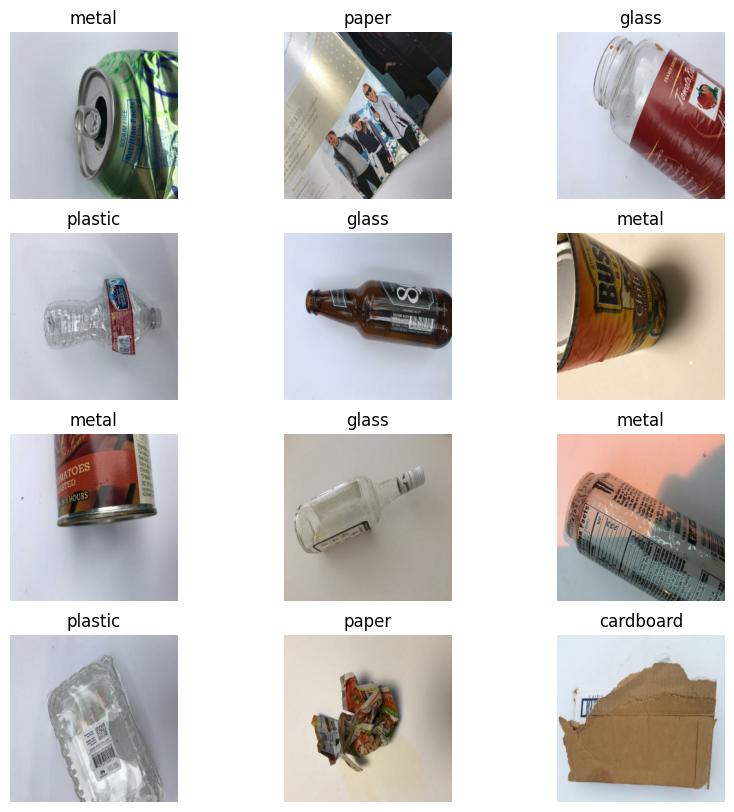

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [9]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts


In [10]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [11]:
class_names = train_ds.class_names

# Helper to count class distribution in dataset
def get_distribution(dataset, class_names):
    counts = {k: 0 for k in class_names}
    total = 0
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[int(label)]
            counts[class_name] += 1
            total += 1

    if total == 0:
        return counts  # avoid ZeroDivisionError

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)
    return counts

# Compute distributions
train_dist = get_distribution(train_ds, class_names)
val_dist = get_distribution(val_ds, class_names)
test_dist = get_distribution(test_ds, class_names)

# Compute overall distribution from train + val
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist.get(k, 0) + val_dist.get(k, 0)) / 2, 2)

# Print results
print("Train Distribution:", train_dist)
print("Validation Distribution:", val_dist)
print("Test Distribution:", test_dist)
print("Overall Distribution (Train + Val Avg):", overall_dist)

Train Distribution: {'cardboard': 16.53, 'glass': 19.5, 'metal': 15.93, 'paper': 23.47, 'plastic': 19.35, 'trash': 5.21}
Validation Distribution: {'cardboard': 13.92, 'glass': 19.68, 'metal': 17.69, 'paper': 24.06, 'plastic': 18.29, 'trash': 6.36}
Test Distribution: {'cardboard': 14.06, 'glass': 21.48, 'metal': 16.8, 'paper': 23.44, 'plastic': 19.53, 'trash': 4.69}
Overall Distribution (Train + Val Avg): {'cardboard': 15.23, 'glass': 19.59, 'metal': 16.81, 'paper': 23.77, 'plastic': 18.82, 'trash': 5.79}


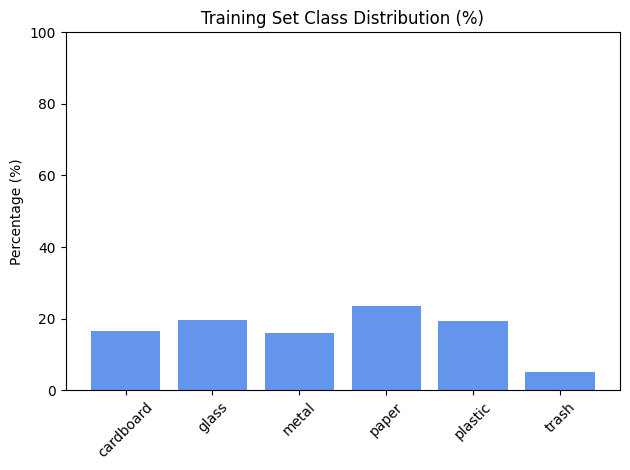

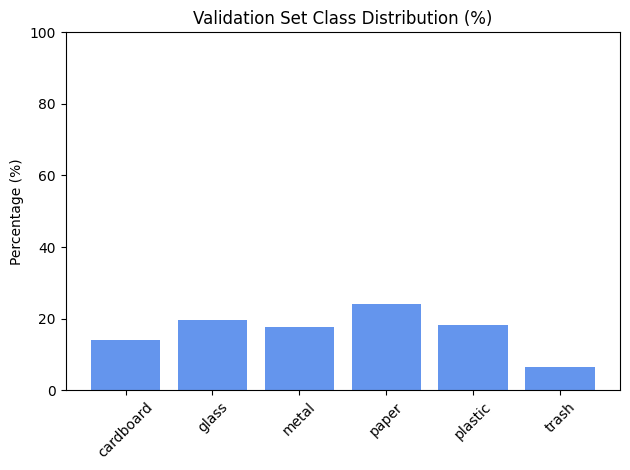

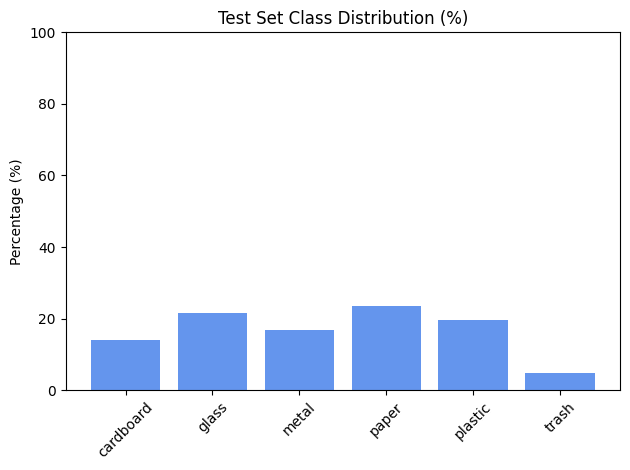

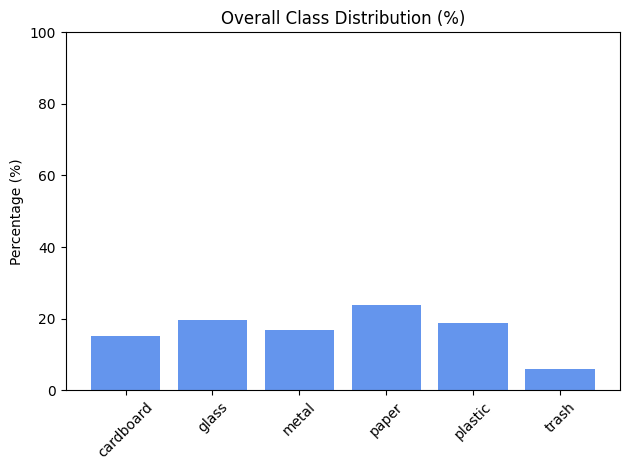

In [12]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [13]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        if isinstance(label, np.ndarray):  # handle one-hot encoded case
            label = np.argmax(label)
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),  # use actual labels present in the data
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in zip(np.unique(all_labels), class_weights_array)}



In [14]:
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 333, 1: 393, 2: 321, 3: 473, 4: 390, 5: 105}
Class Weights: {np.int32(0): np.float64(1.0085085085085086), np.int32(1): np.float64(0.8545377438507209), np.int32(2): np.float64(1.046209761163032), np.int32(3): np.float64(0.7100070472163496), np.int32(4): np.float64(0.8611111111111112), np.int32(5): np.float64(3.1984126984126986)}


In [15]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [16]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(260, 260, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False



In [17]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(260, 260, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [18]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [19]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


In [20]:
# Fix class_weights to reindex from 0
label_mapping = {label: idx for idx, label in enumerate(sorted(set(all_labels)))}
mapped_labels = [label_mapping[label] for label in all_labels]

from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(label_mapping)),
    y=mapped_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [21]:
# 📝 Summary (optional but useful)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [22]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 758s 11s/step - accuracy: 0.4357 - loss: 1.5323 - val_accuracy: 0.7654 - val_loss: 0.8307
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 689s 10s/step - accuracy: 0.7897 - loss: 0.6853 - val_accuracy: 0.8549 - val_loss: 0.4807
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 713s 11s/step - accuracy: 0.8899 - loss: 0.3723 - val_accuracy: 0.8847 - val_loss: 0.3606
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 684s 11s/step - accuracy: 0.9203 - loss: 0.2618 - val_accuracy: 0.9026 - val_loss: 0.2935
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 692s 11s/step - accuracy: 0.9624 - loss: 0.1595 - val_accuracy: 0.9085 - val_loss: 0.2588
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 669s 11s/step - accuracy: 0.9663 - loss: 0.1281 - val_accuracy: 0.9125 - val_loss: 0.2504
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 764s 12s/step - accuracy: 0.9679 - loss: 0.1037 - val_accuracy: 0.9125 - val_loss: 0.2314
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 701s 10s/step - accuracy: 0.9819 - loss: 0.0765 - val_accuracy: 0.

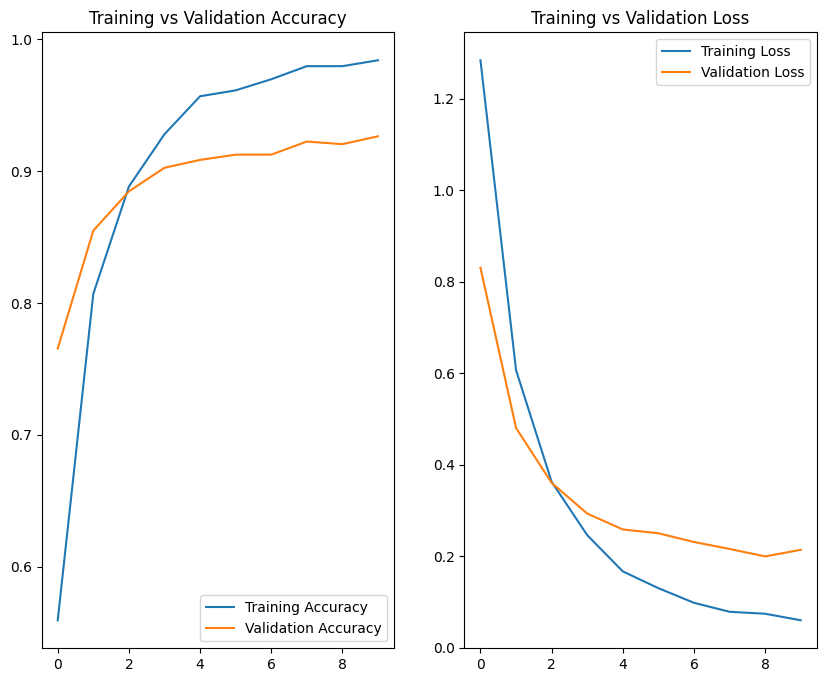

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

In [24]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.9348 - loss: 0.1851
Test accuracy is0.9336, Test loss is 0.2081


In [25]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step
[[26  0  1  1  0  0]
 [ 0 50  1  0  2  0]
 [ 0  0 48  0  1  0]
 [ 1  0  0 51  0  2]
 [ 0  2  3  1 47  0]
 [ 0  1  1  0  0 17]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       0.94      0.94      0.94        53
           2       0.89      0.98      0.93        49
           3       0.96      0.94      0.95        54
           4       0.94      0.89      0.91        53
           5       0.89      0.89      0.89        19

    accuracy                           0.93       256
   macro avg       0.93      0.93      0.93       256
weighted avg       0.93      0.93      0.93       256



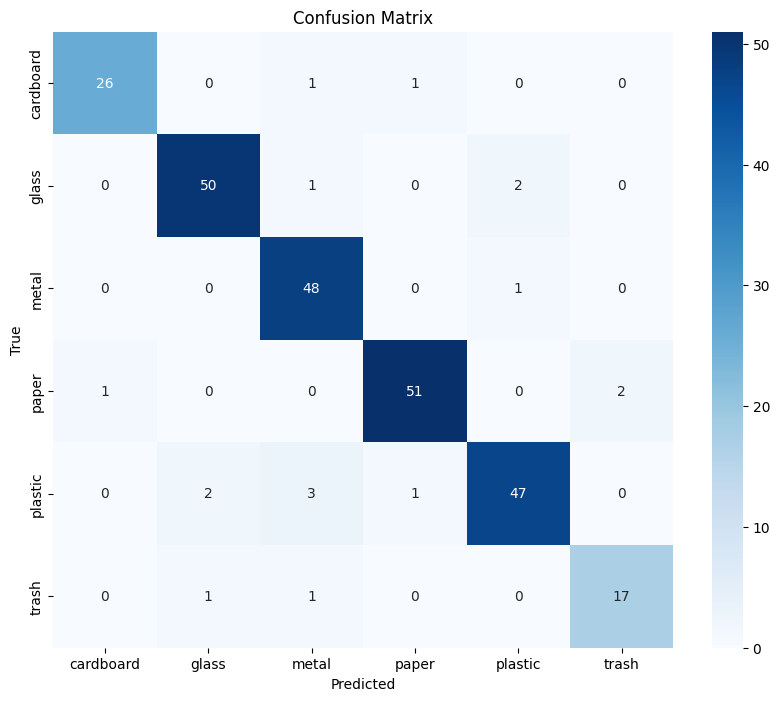

In [26]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


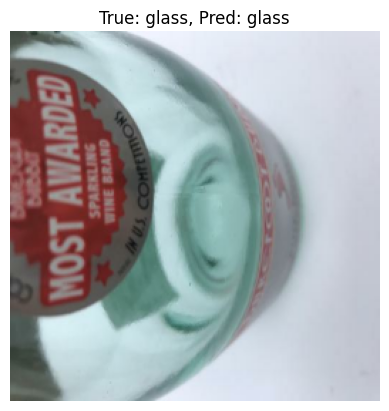

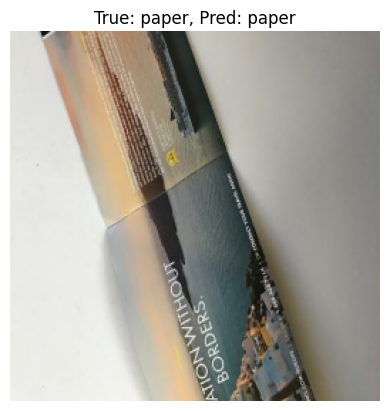

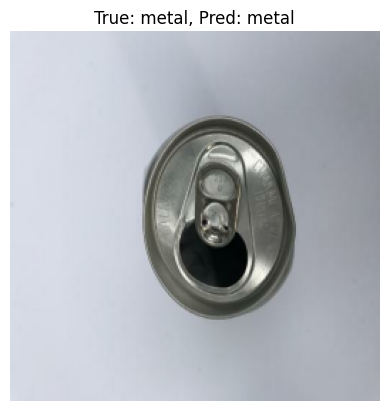

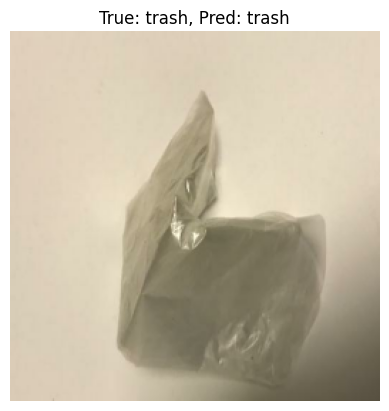

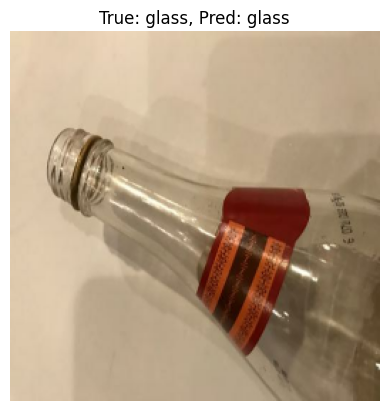

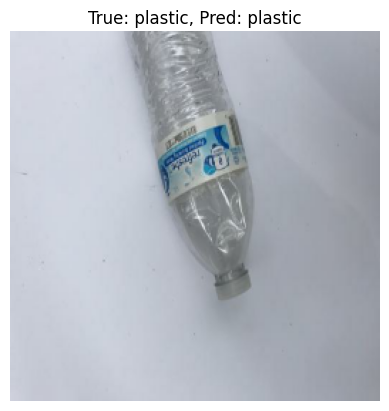

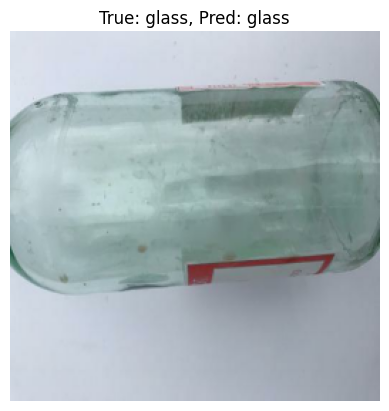

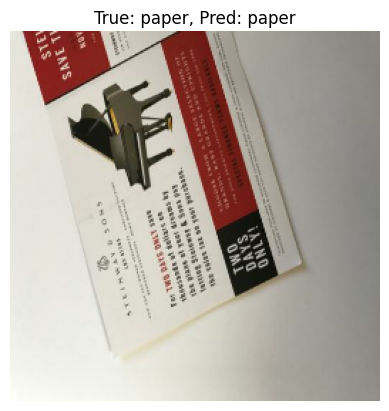

In [27]:
# Extract class names from the training dataset
class_names = train_ds.class_names

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):

    # Generate predictions for the batch of images
    predictions = model.predict(images)

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)

    # Loop through the first 8 images in the batch
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [28]:
model.save('/content/drive/MyDrive/garbage_model2.h5')


In [29]:
#!pip install gradio

In [30]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [31]:
def classify_image(img):
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((260, 260))

    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

In [32]:
iface = gr.Interface(
    fn=classify_image,  # Function to classify image using the trained model
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image
    outputs="text"  # Outputs prediction as text
)

# Launch the interface
iface.launch()  # Start the Gradio interface for user interaction

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c782a4d4f1259af75f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
